C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


1/1 [==============================] - 4s 4s/step


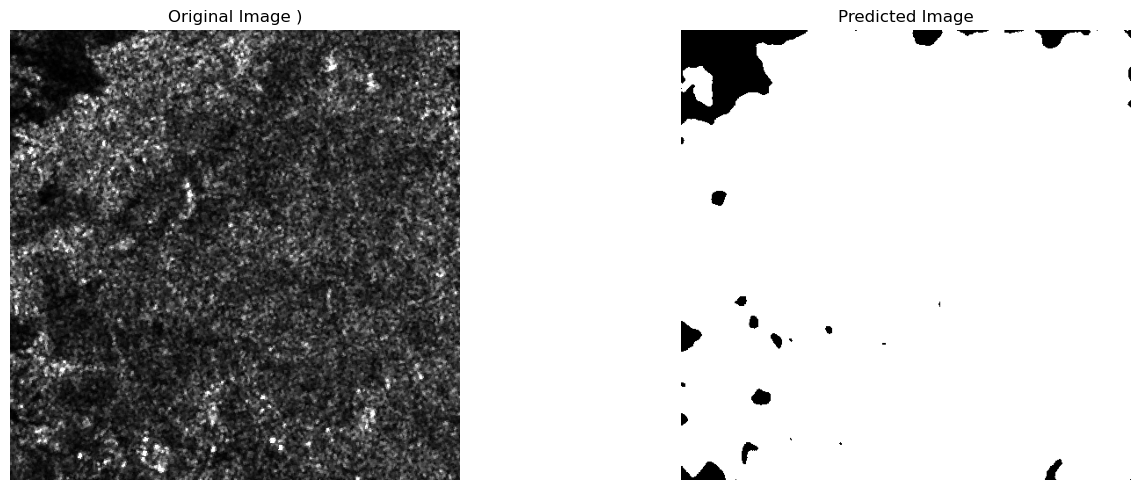

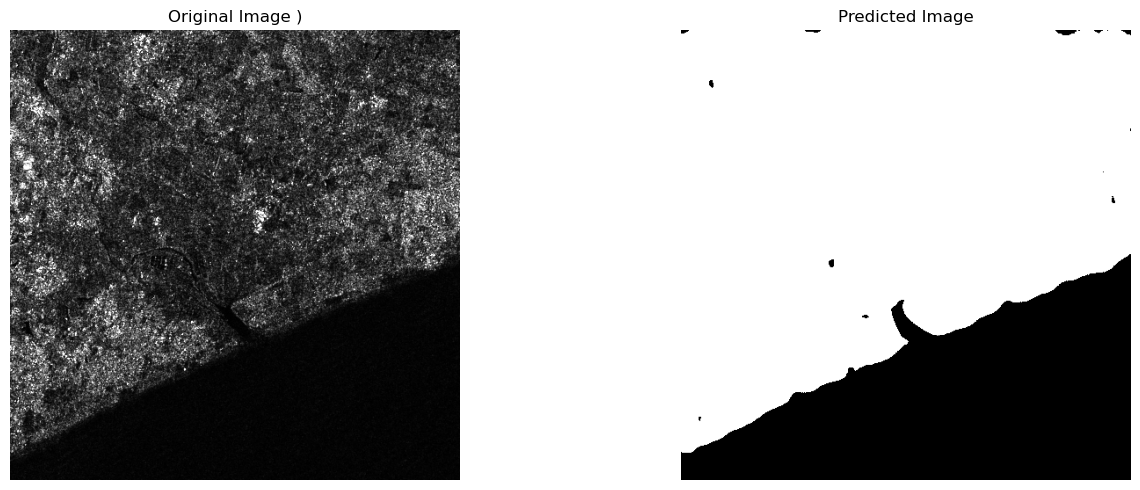

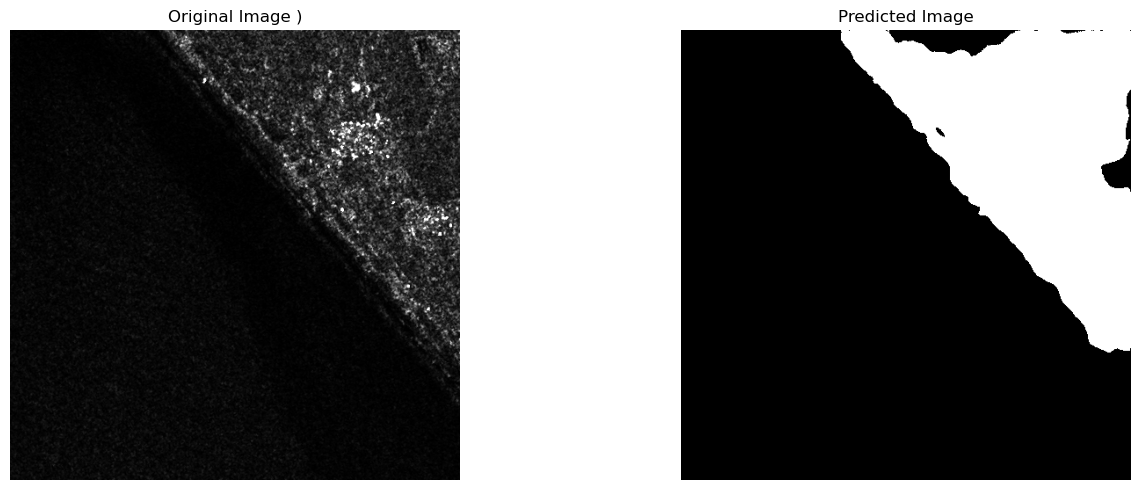

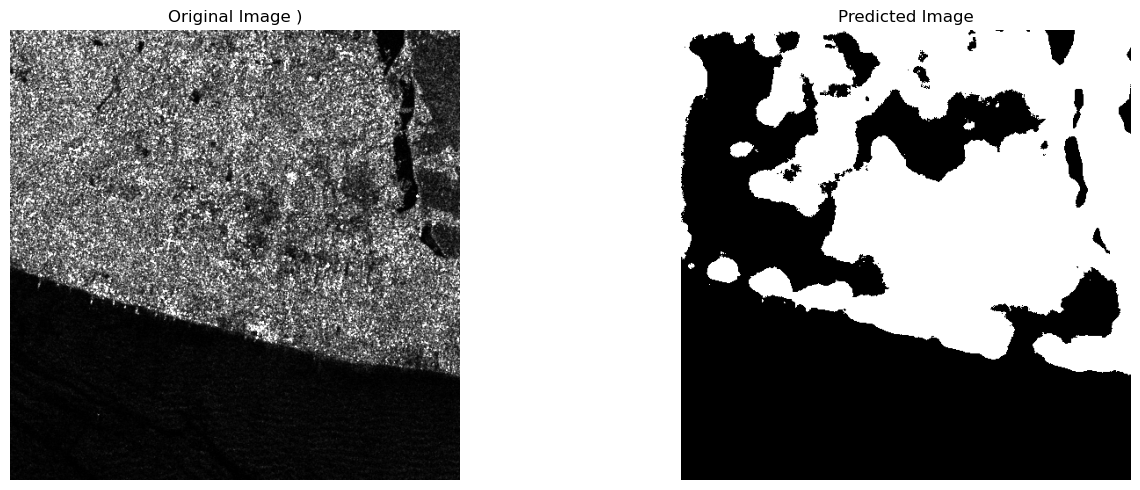

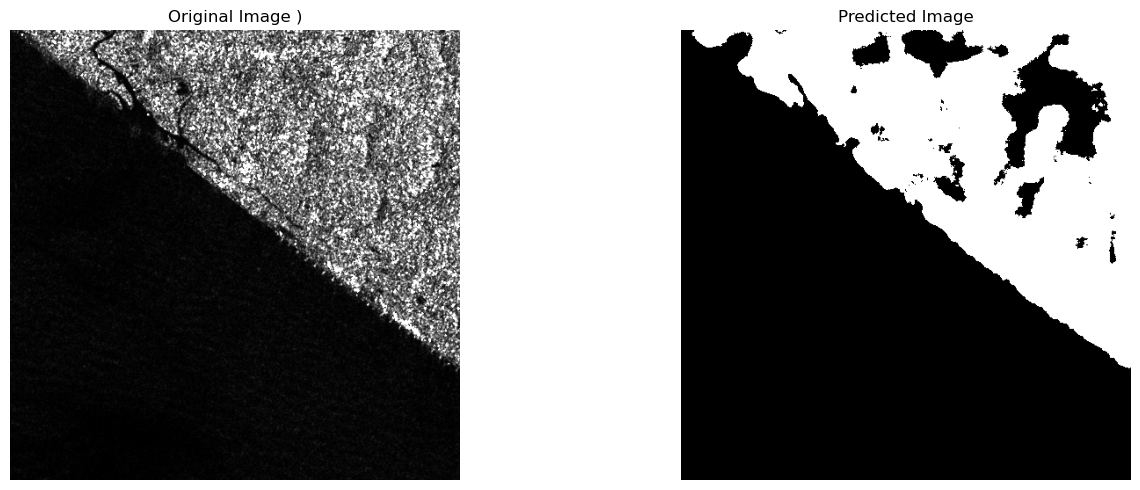

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from keras.models import load_model

# Model and image properties
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
model = load_model('UNet-built.h5')
#model = load_model('UNetv3.h5')
TERRAIN = 'natural'
START_NUM=1
# Placeholder for inputs
X_test = np.zeros((5, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
original_sizes=[]
for i in range(5):
    # Read the original image
    img = imread(rf'test\{TERRAIN}\images\{i+START_NUM}.tiff')[:,:,:IMG_CHANNELS]
    original_sizes.append(img.shape[:2])  # Store original size for resizing later

    # Resize the image for the model
    img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[i] = img_resized  # Correct index to i instead of i-1

preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

for i in range(len(preds_test_t)):
    # Resize the predicted image back to original size
    pred_image_resized = resize(np.squeeze(preds_test_t[i]), original_sizes[i], mode='constant', preserve_range=True)
    pred_image_resized = (pred_image_resized > 0.5).astype(np.uint8) * 255  # Threshold and scale back to 0-255

    # Plotting and saving the results
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(X_test[i])
    axs[0].title.set_text(f'Original Image )')
    axs[0].axis('off')
    axs[1].imshow(pred_image_resized, cmap='gray')
    axs[1].title.set_text('Predicted Image')
    axs[1].axis('off')
    plt.tight_layout()

    #plt.savefig(f'VH-image-on-VV-Model-{i}.png')  # Save the plot first
    plt.show()  # Then display the plot
    imsave(rf'test\{TERRAIN}\results\{i+START_NUM}_pred.tiff', pred_image_resized.astype(np.uint8))


1/1 [==============================] - 0s 135ms/step


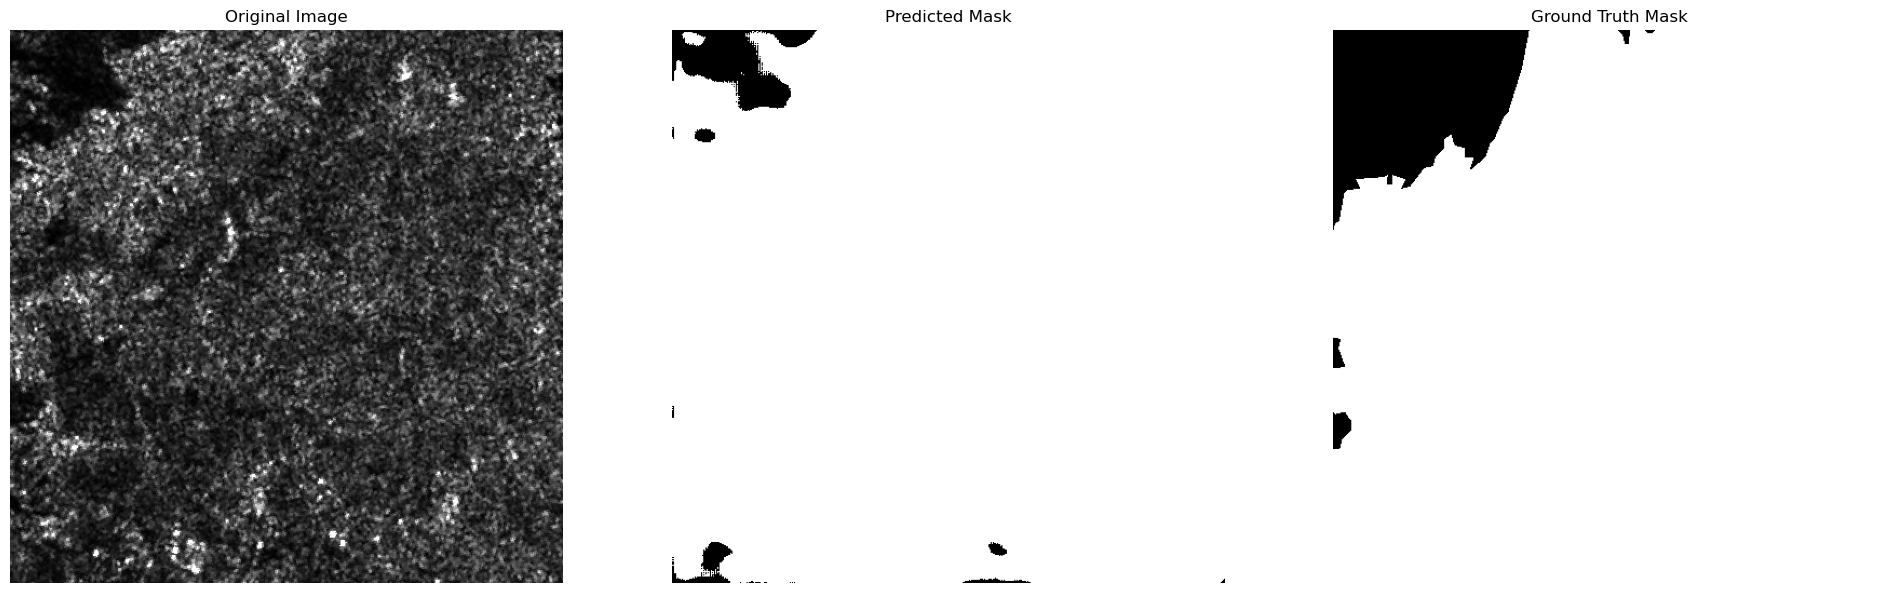

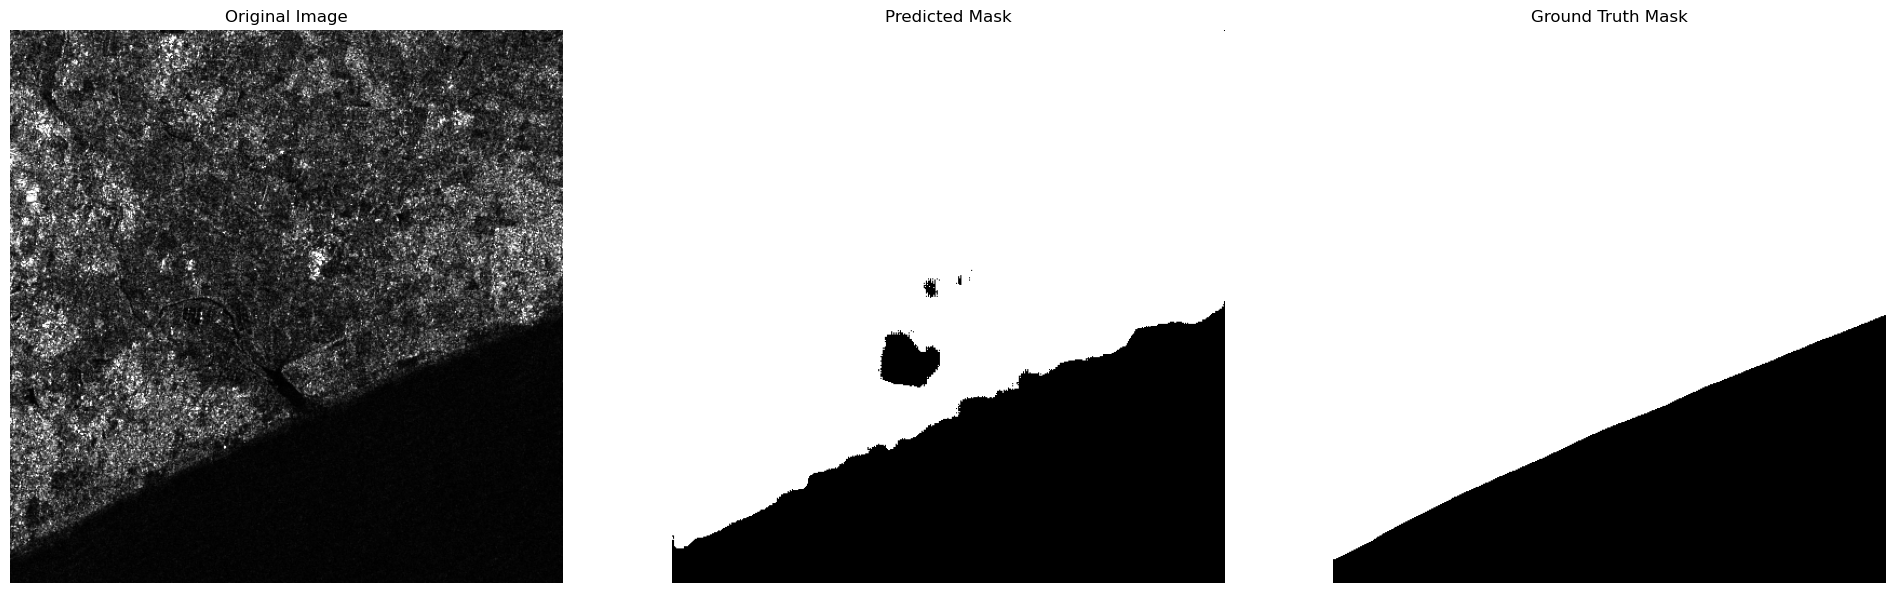

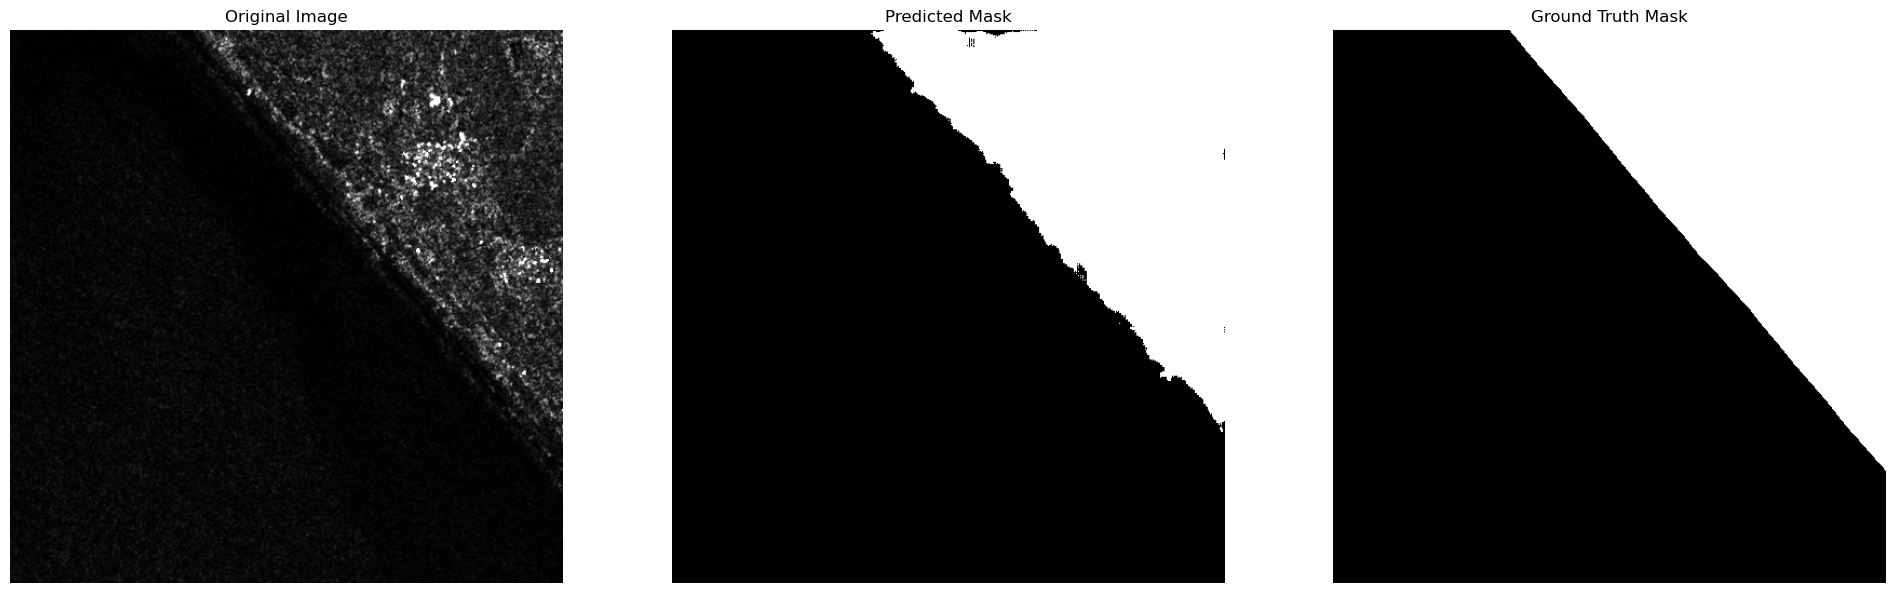

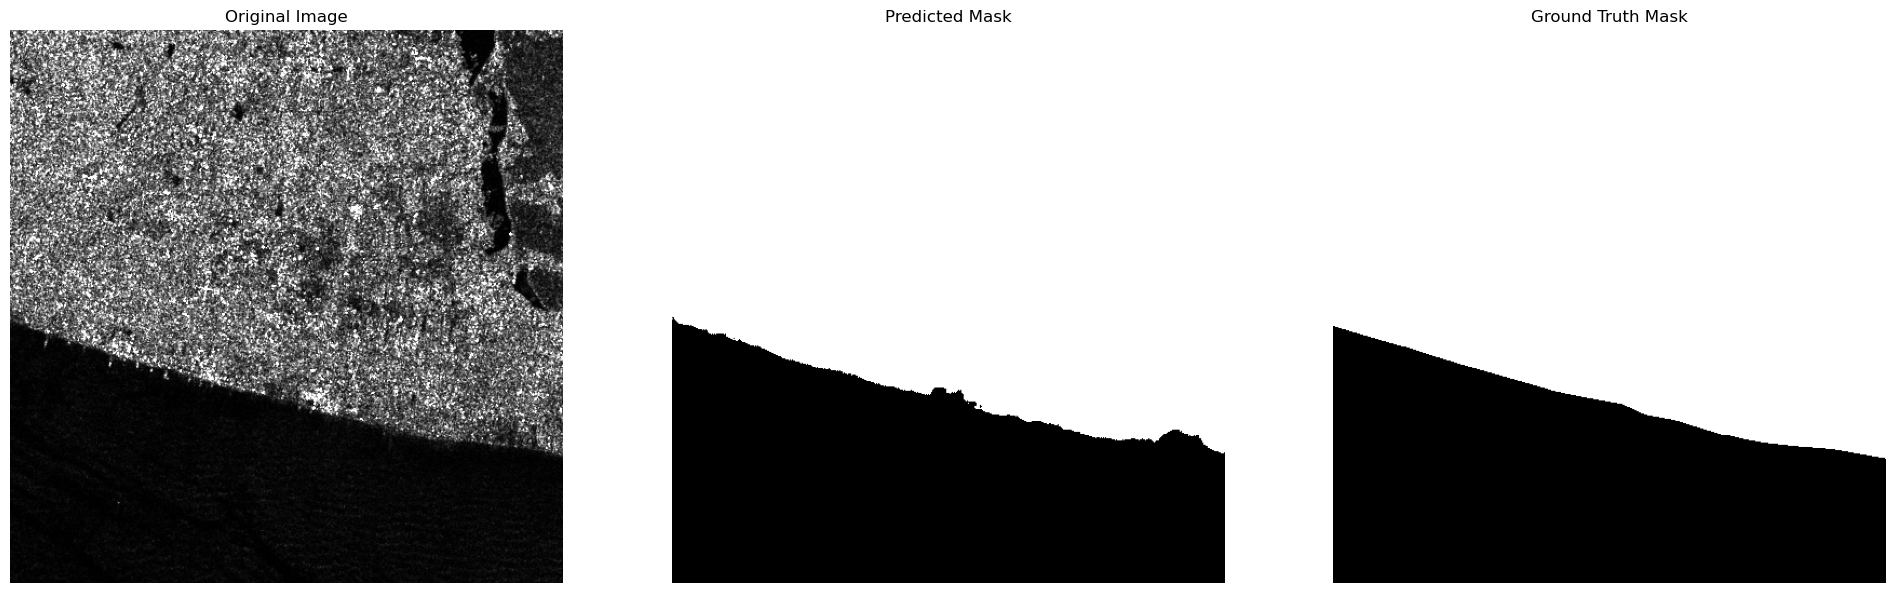

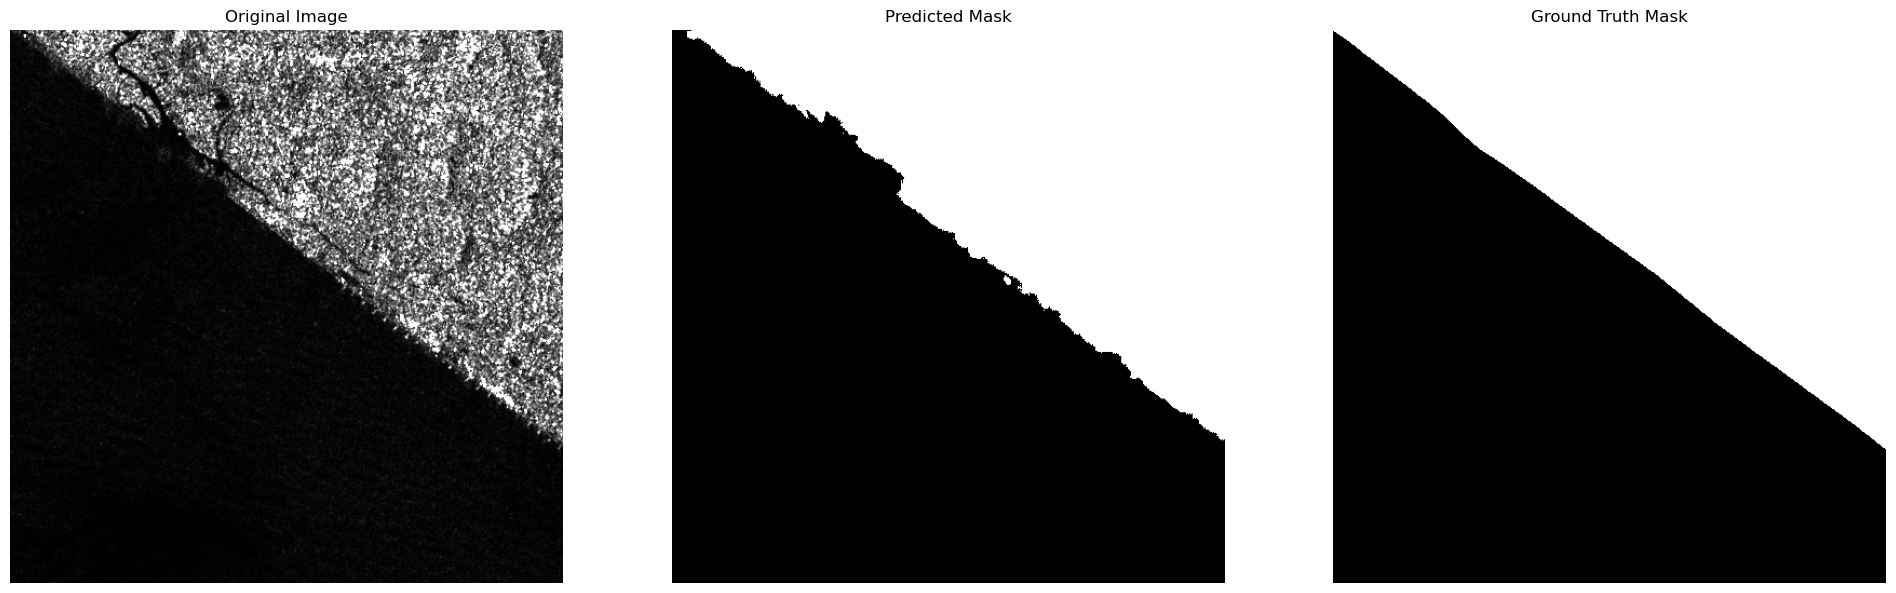

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from keras.models import load_model

# Model and image properties
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
model = load_model('UNet-natural.h5')

# Placeholder for inputs
X_test = np.zeros((5, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
truth_masks = np.zeros((5, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)  # For storing truth masks
original_sizes=[]
for i in range(5):
    # Read the original image
    img = imread(rf'test\{TERRAIN}\images\{i+START_NUM}.tiff')[:,:,:IMG_CHANNELS]
    original_sizes.append(img.shape[:2])  # Store original size for resizing later

    # Resize the image for the model
    img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[i] = img_resized

    # Load and resize the truth mask
    mask = imread(rf'test\{TERRAIN}\masks\{i+START_NUM}_mask.tiff')
    if mask.ndim == 3:
        mask = mask[:,:,0]  # Assume the mask is greyscale but might be in a 3-channel image format
    truth_mask_resized = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    truth_masks[i] = (truth_mask_resized > 0.5).astype(np.uint8)  # Threshold after resizing

preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

for i in range(len(preds_test_t)):
    # Plot results
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    axs[0].imshow(X_test[i])
    axs[0].title.set_text('Original Image')
    axs[0].axis('off')
    axs[1].imshow(preds_test_t[i], cmap='gray')
    axs[1].title.set_text('Predicted Mask')
    axs[1].axis('off')
    axs[2].imshow(truth_masks[i], cmap='gray')
    axs[2].title.set_text('Ground Truth Mask')
    axs[2].axis('off')
    plt.tight_layout()

    plt.show()  # Display the plot
    


In [2]:
from PIL import Image
import numpy as np

def calculate_iou(image_path, mask_path):
    # Load image and mask
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Convert images to numpy arrays
    image_array = np.array(image)
    mask_array = np.array(mask)

    # Handle multi-channel images or masks
    if image_array.ndim == 3:
        image_array = image_array[:, :, 0]  # Use the first channel of the image
    if mask_array.ndim == 3:
        mask_array = mask_array[:, :, 0]    # Use the first channel of the mask

    # Binarize images: pixels above a threshold become 1, others become 0
    # Assuming 255 is the foreground in both image and mask
    image_array = np.where(image_array == 255, 1, 0)
    mask_array = np.where(mask_array == 255, 1, 0)

    # Calculate intersection and union
    intersection = np.logical_and(image_array, mask_array)
    union = np.logical_or(image_array, mask_array)

    # Calculate IoU
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0

    return iou

a = []
for i in range(5):  # Assuming you are running this for images indexed from 142 to 151
    image_path = rf'test\{TERRAIN}\masks\{i+START_NUM}_mask.tiff'
    mask_path = rf'test\{TERRAIN}\results\{i+START_NUM}_pred.tiff'
    iou = calculate_iou(image_path, mask_path)
    a.append(iou)
    print(f"Image {i+START_NUM}: IoU = {iou}")

print(f"Average IoU = {sum(a)/len(a)}")


Image 1: IoU = 0.930389622671248
Image 2: IoU = 0.9790773407126435
Image 3: IoU = 0.895230495709266
Image 4: IoU = 0.6614486299813696
Image 5: IoU = 0.8083391904332934
Average IoU = 0.854897055901564
